In [1]:
import rasterio
import matplotlib.pyplot as plt

path= r"C:\Users\Icy\Documents\CEU\Geospatial\IslandsDEMv1.0_2x2m_zmasl_isn2016_47.tif"

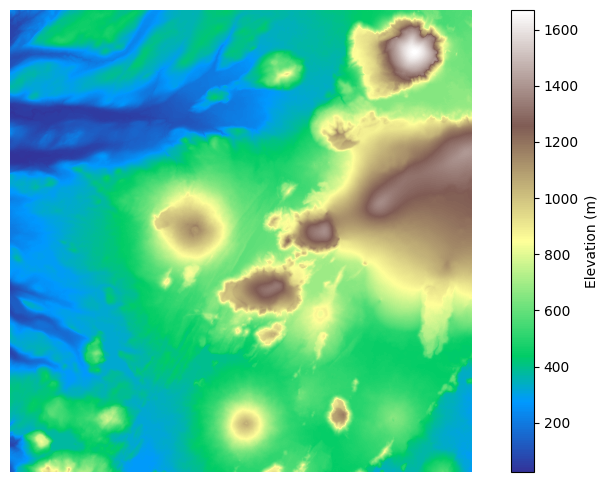

In [2]:
with rasterio.open(path) as src:
    dem = src.read(1)
    profile = src.profile

#size reduction by 10-fold so size is managable 
downsampled = dem[::10, ::10] 

plt.figure(figsize=(10, 6))
plt.imshow(downsampled, cmap='terrain')
plt.colorbar(label="Elevation (m)")
plt.axis('off')
plt.show()

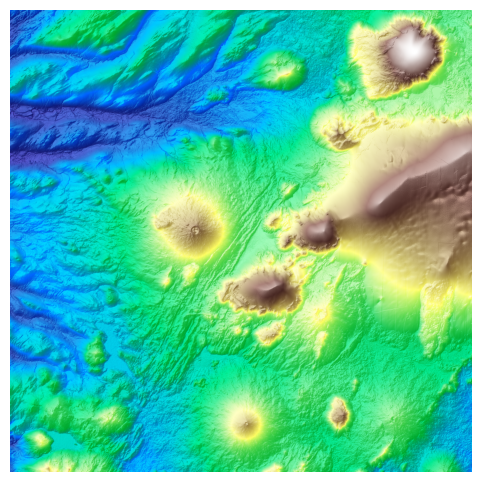

In [3]:
from matplotlib.colors import LightSource
import numpy as np

#exaggerating patterns for image recognition
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.shade(downsampled, cmap=plt.cm.terrain, blend_mode='soft', vert_exag=4) #tuning so it gives the best fine edges 

plt.figure(figsize=(10, 6))
plt.imshow(hillshade)
plt.axis('off')
plt.show()

In [4]:
#function to slice and extract land patches for readings 
def extract_patches(array, size, stride): 
    patches = []
    coords = []
    for i in range(0, array.shape[0] - size, stride):      
        for j in range(0, array.shape[1] - size, stride):
            patch = array[i:i+size, j:j+size]
            if np.isnan(patch).any():
                continue
            patches.append(patch)
            coords.append((i, j))
    return patches, coords

patches, coords = extract_patches(hillshade[:, :, :3], size=256, stride=128) #for this 50% layover between patches seemed fine
print("extracted:", len(patches))

extracted: 324


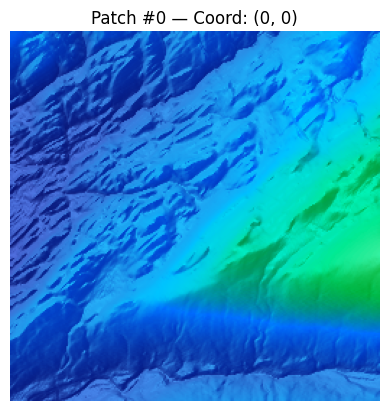

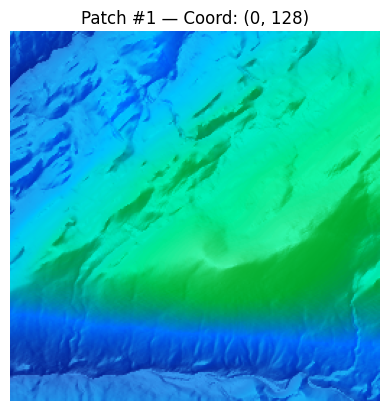

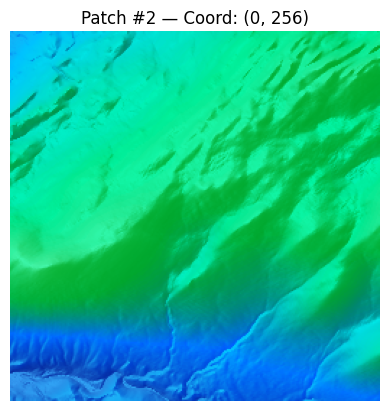

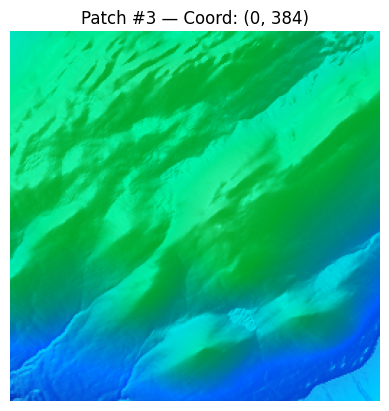

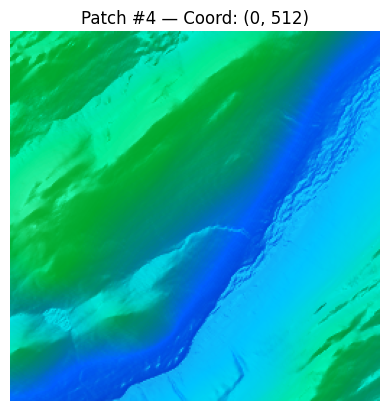

In [5]:
#plotting for inspection
for i in range(min(5, len(patches))):
        plt.imshow(patches[i], cmap='gray' if patches[i].ndim == 2 else None)
        plt.title(f"Patch #{i} — Coord: {coords[i]}")
        plt.axis('off')
        plt.show()

In [6]:
import numpy as np
import torch
import clip
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

#openAI's clip model is loaded 
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

#processing patches into 224x224 images and RBG
def prepare_patch_for_clip(patch):
    patch_img = Image.fromarray(patch).convert("RGB")
    return preprocess(patch_img)

C:\Users\Icy\anaconda3\envs\tarot-env\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [53]:
#prompts were picked on an arbitrary basis, to reflect natural formations of geographical points of interest
#and a bit of game-ified to add to the interactive part of the mini-project

prompts = [   "dusty slope downwards",
    "a volcanic crater",
    "a layered rock formation",
    "red swirls of magma",
    "a mountain towering above",
    "a scarred hillside",
    "a cracked desert floor",
    "icicles of splendor",
    "a glacial path",
    "stones of solutide",
    "a whirling lava slide",
    "a scorched wound from the earth",
    "thunderstorm"]

#prompts are turned into vectors and fed to the model
text_tokens = clip.tokenize(prompts).to(device)

#encoding and vector normalization
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [54]:
batch_embeddings = []
patch_images = []

def prepare_patch_for_clip(patch):
    # If patch is float, normalize it to 0–255 and convert to uint8
    if patch.dtype != np.uint8:
        patch = patch - patch.min()
        if patch.max() > 0:
            patch = patch / patch.max()
        patch = (patch * 255).astype(np.uint8)

    # PIL image conversion for model
    img = Image.fromarray(patch).convert("RGB")
    return preprocess(img)

    
num_patches_to_try =324 #can be adjusted to save computing time

#runnig the patches through the model
for i in range(num_patches_to_try):
    tensor = prepare_patch_for_clip(patches[i])
    patch_images.append(tensor)

image_input = torch.stack(patch_images).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)

similarity = image_features @ text_features.T

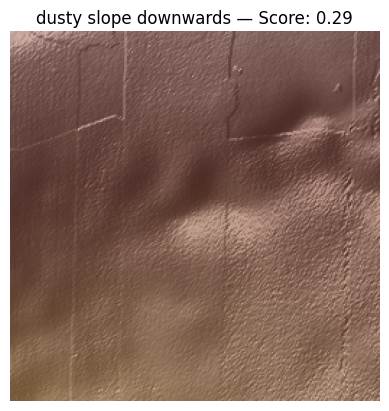

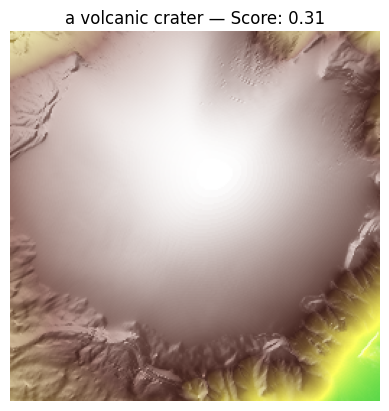

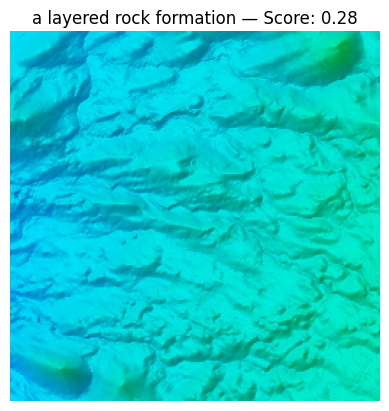

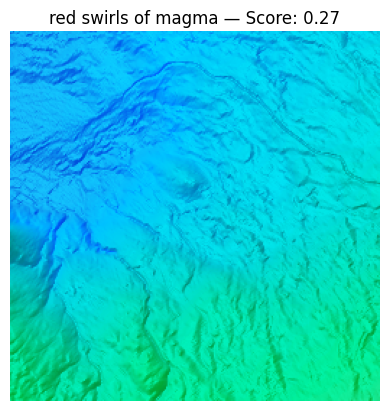

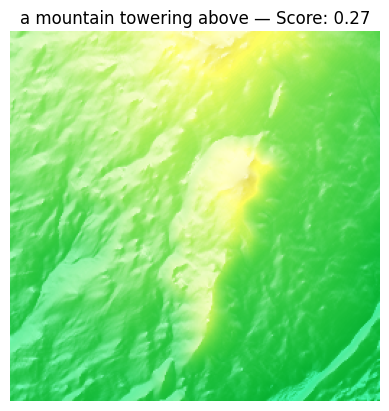

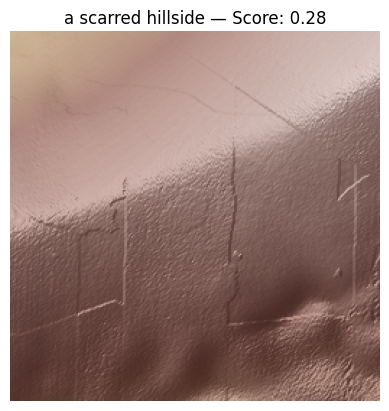

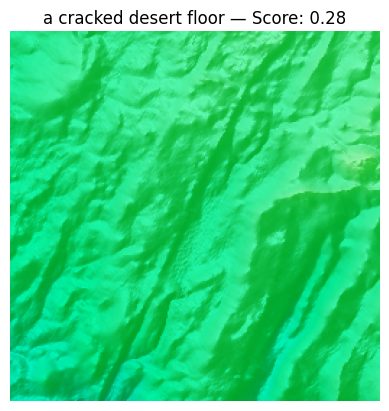

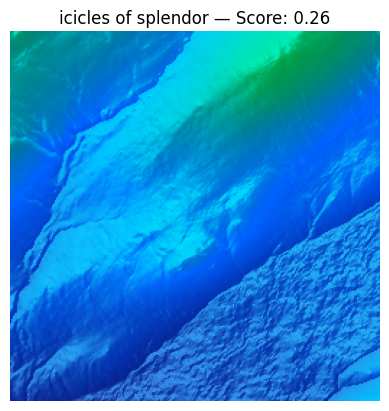

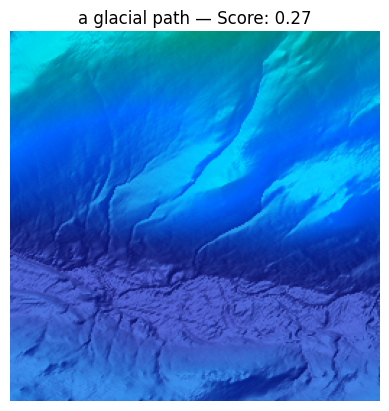

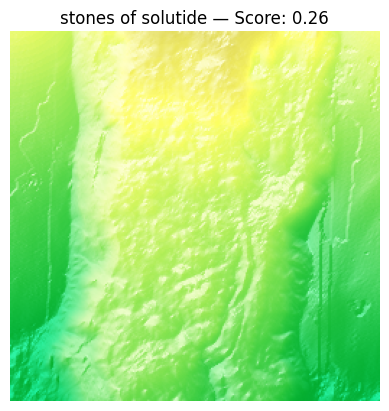

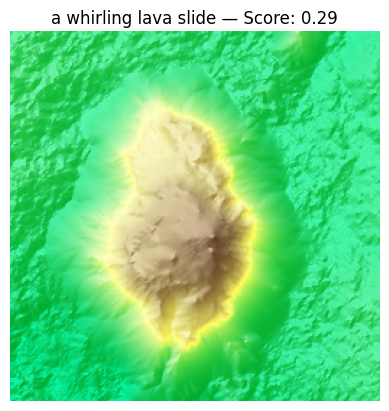

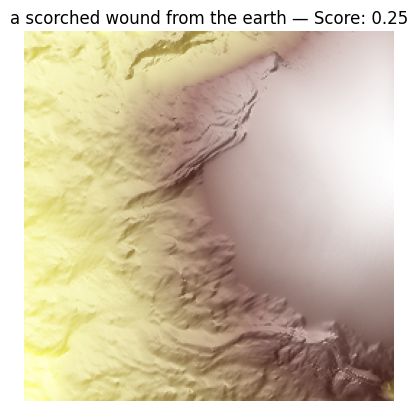

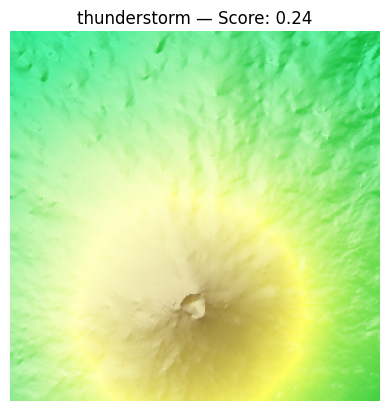

In [55]:
import matplotlib.pyplot as plt

top_matches = {}

#matching each prompt to its best patch
for i, prompt in enumerate(prompts):
    top_idx = similarity[:, i].argmax().item()
    score = similarity[top_idx, i].item()
    top_matches[prompt] = (top_idx, score)

    plt.imshow(patches[top_idx], cmap="gray")
    plt.title(f"{prompt} — Score: {score:.2f}")
    plt.axis("off")
    plt.show()

In [56]:
interpretations = {
    "dusty slope downwards": "Descent is not defeat — it’s where things settle into shape.",
    "a volcanic crater": "From destruction rises clarity.",
    "a layered rock formation": "Time reveals itself in patient layers.",
    "red swirls of magma": "Beneath beauty, something volatile moves with purpose.",
    "a mountain towering above": "Your challenge stands clear — and so does your strength.",
    "a scarred hillside": "Old wounds shape the new terrain.",
    "a cracked desert floor": "Silence is full of unseen echoes.",
    "icicles of splendor": "Beauty forms in the coldest moments.",
    "a glacial path": "Slow progress carves enduring marks.",
    "stones of solutide": "The quiet weight of stillness holds truth.",
    "a whirling lava slide": "Unstoppable force reshapes everything in its way.",
    "a scorched wound from the earth": "The land remembers every eruption.",
    "thunderstorm": "Even chaos carries the seeds of renewal."
}

In [69]:
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

#fmatch scores are relatively close and less fun, scaling them for better display
def normalize_spiritual_score(raw_score, raw_min=0.2, raw_max=0.3, target_min=20, target_max=95):
    normalized = (raw_score - raw_min) / (raw_max - raw_min)
    return int(target_min + normalized * (target_max - target_min))

#interactive aspect to show cards to user
def draw_terrain_tarot(image_features, text_features, patches, prompts, coords=None):
    output = widgets.Output()

    def draw_cards(_=None):
        with output:
            clear_output(wait=True)
            similarities = (image_features @ text_features.T).cpu().numpy()
            chosen_cards = []
            used_idxs = set()

            fig, axs = plt.subplots(1, 3, figsize=(14, 5))

            for ax, prompt_idx in zip(axs, random.sample(range(len(prompts)), 3)):
                best_idx = similarities[:, prompt_idx].argmax()
                while best_idx in used_idxs:
                    similarities[best_idx, prompt_idx] = -1
                    best_idx = similarities[:, prompt_idx].argmax()

                used_idxs.add(best_idx)

                patch = patches[best_idx]
                prompt = prompts[prompt_idx]
                title = prompt.replace("a ", "").title()
                raw_score = similarities[best_idx, prompt_idx]
                score = normalize_spiritual_score(raw_score)
                interp = interpretations.get(prompt, "The land speaks in riddles.")

                ax.imshow(patch)
                ax.set_title(f"{title}\n{interp}\n Spiritual Score: {score}", fontsize=10)
                ax.axis('off')

            plt.suptitle("✦ ✦ ↟ Your Fortune in Shape and Stone ↟ ✦ ✦ ", fontsize=16, y=1.05)
            plt.tight_layout()
            plt.show()

    redraw_btn = widgets.Button(description="Redraw Cards 🔮")
    redraw_btn.on_click(draw_cards)

    display(redraw_btn, output)
    draw_cards()

In [70]:
draw_terrain_tarot(image_features, text_features, patches, prompts)

Button(description='Redraw Cards 🔮', style=ButtonStyle())

Output()